<a href="https://colab.research.google.com/github/ShimitaRudra/DataAnalytics-Thesis/blob/main/Drug_reviews_DA_project_BCB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install transformers >> NULL

### Already installed packages

In [ ]:
#!pip install -U spacy

In [ ]:
#!pip install -U spacy[cuda118]

In [ ]:
#!pip install scispacy

In [ ]:
#!pip install -U scispacy

In [ ]:
#!pip install pyarrow

In [ ]:
#!pip install fastparquet

In [ ]:
#!pip install spacy-transformers >> a

In [ ]:
#pip install '/content/drive/MyDrive/Colab Notebooks/Data Analytics Project/en_ner_bc5cdr_md-0.5.1.tar.gz'

### Import statementss

In [ ]:
import pandas as pd
import numpy as np
import spacy
import spacy_transformers
import scispacy
from spacy import displacy
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from transformers import AutoTokenizer, AutoModel, AdamW, get_linear_schedule_with_warmup, AutoConfig

import torch
import torch.nn as nn
import pickle

from tqdm.notebook import tqdm
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
print("CUDA Version:", torch.version.cuda)

CUDA Version: 11.8


### Save and Load Balanced + Sciscpacy + Tokenize Filtered df

In [ ]:
#Load df
df=pd.read_parquet('/content/drive/MyDrive/Colab Notebooks/Data Analytics Project/df_clean_save/df_bal_scispacy_filter.parquet')

In [ ]:
df.info() #118699 | memory usage: 7.2+ MB | 7 columns

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118699 entries, 0 to 118703
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   drugName         118699 non-null  object
 1   condition        118699 non-null  object
 2   rating           118699 non-null  int64 
 3   label            118699 non-null  int64 
 4   label_name       118699 non-null  object
 5   scispacy_review  118699 non-null  object
 6   bert_token_len   118699 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 7.2+ MB


In [ ]:
df = df.rename(columns = {'scispacy_review':'review'})

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118699 entries, 0 to 118703
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   drugName        118699 non-null  object
 1   condition       118699 non-null  object
 2   rating          118699 non-null  int64 
 3   label           118699 non-null  int64 
 4   label_name      118699 non-null  object
 5   review          118699 non-null  object
 6   bert_token_len  118699 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 7.2+ MB


### Extra Config

In [ ]:
#Following B. Biseda and K. Mo, “Enhancing pharmacovigilance with drug reviews and
#social media,” arXiv preprint arXiv:2004.08731, 2020. 6, 8, 15
'''
class Config():
    epochs = 10
    batch_size = 32
    max_length = 128 #250
    lr = 2e-5
    hidden_size = 128
    epsilon = 1e-8
    random_state=100
    add_special_tokens=True
    return_attention_mask=True
    padding='max_length'
    truncation=True
    return_token_type_ids=False
    return_tensors='pt'
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

config = Config()
'''

In [ ]:
#Following A. Shiju and Z. He, “Classifying drug ratings using user reviews with
#transformer-based language models,” in 2022 IEEE 10th International Conference
#on Healthcare Informatics (ICHI), 2022, pp. 163–169. 7, 8, 15
'''
class Config():
    epochs = 10
    batch_size = 6
    max_length = 512
    lr = 5e-5
    hidden_size = 128
    epsilon = 1e-8
    random_state=100
    add_special_tokens=True
    return_attention_mask=True
    padding='max_length'
    truncation=True
    return_token_type_ids=False
    return_tensors='pt'
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

config = Config()
'''

### Config

In [ ]:
#Following C. Col´on-Ruiz and I. Segura-Bedmar, “Comparing deep learning architectures for sentiment analysis on drug reviews,” Journal of
#Biomedical Informatics, vol. 110, p. 103539, 2020. [Online]. Available:
#https://www.sciencedirect.com/science/article/pii/S1532046420301672

class Config():
    epochs = 40
    batch_size = 200
    max_length = 250 #512
    lr = 0.001
    hidden_size = 128
    epsilon = 1e-8
    random_state=100
    add_special_tokens=True
    return_attention_mask=True
    padding='max_length'
    truncation=True
    return_token_type_ids=False
    return_tensors='pt'
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

config = Config()


In [ ]:
params = {
    "epochs":config.epochs,
    "batch_size":config.batch_size,
    "max_length":config.max_length,
    "lr":config.lr,
    "hidden_size":config.hidden_size,
    "eps":config.epsilon,
    "random_state":config.random_state,
    "add_special_tokens":config.add_special_tokens,
    "return_attention_mask":config.return_attention_mask,
    "padding":config.padding,
    "truncation":config.truncation,
    "return_token_type_ids":config.return_token_type_ids,
    "return_tensors":config.return_tensors,
    "device":str(config.device),
         }

In [ ]:
device = config.device
device

device(type='cuda', index=0)

In [ ]:
torch.cuda.is_available()

True

### Train Test split

In [ ]:
train_df, temp_df = train_test_split(df,test_size=0.3,random_state=100)

val_df, test_df = train_test_split(temp_df,test_size=0.5,random_state=100)
#70:15:15

In [ ]:
print(len(train_df['label'].unique()))
print("TrainDF:",train_df.shape)
print(len(val_df['label'].unique()))
print("Valdf:",val_df.shape)
print(len(test_df['label'].unique()))
print("Testdf:",test_df.shape)

3
TrainDF: (83089, 7)
3
Valdf: (17805, 7)
3
Testdf: (17805, 7)


In [ ]:
train_df.info() #83089 | memory usage: 5.1+ MB | 7 columns

<class 'pandas.core.frame.DataFrame'>
Int64Index: 83089 entries, 32168 to 38409
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   drugName        83089 non-null  object
 1   condition       83089 non-null  object
 2   rating          83089 non-null  int64 
 3   label           83089 non-null  int64 
 4   label_name      83089 non-null  object
 5   review          83089 non-null  object
 6   bert_token_len  83089 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 5.1+ MB


### Bio Clinical BERT

In [ ]:
tokenizer_bcb = AutoTokenizer.from_pretrained('emilyalsentzer/Bio_ClinicalBERT')

model_bcb = AutoModel.from_pretrained('emilyalsentzer/Bio_ClinicalBERT')
#model = model.to(device)

In [ ]:
model_bcb

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(28996, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

#### Batch Encode into input id, attention mask

In [ ]:
train_encoded = tokenizer_bcb.batch_encode_plus(train_df.review.values.tolist(),
                                                 add_special_tokens=config.add_special_tokens,
                                                 return_attention_mask=config.return_attention_mask,
                                                 padding=config.padding,
                                                 max_length=config.max_length,
                                                 truncation = config.truncation,
                                                 return_token_type_ids = config.return_token_type_ids,
                                                 return_tensors=config.return_tensors)

In [ ]:
val_encoded = tokenizer_bcb.batch_encode_plus(val_df.review.values.tolist(),
                                               add_special_tokens=config.add_special_tokens,
                                               return_attention_mask=config.return_attention_mask,
                                               padding=config.padding,
                                               max_length=config.max_length,
                                               truncation = config.truncation,
                                               return_token_type_ids = config.return_token_type_ids,
                                               return_tensors=config.return_tensors)

In [ ]:
test_encoded = tokenizer_bcb.batch_encode_plus(test_df.review.values.tolist(),
                                               add_special_tokens=config.add_special_tokens,
                                               return_attention_mask=config.return_attention_mask,
                                               padding=config.padding,
                                               max_length=config.max_length,
                                               truncation = config.truncation,
                                               return_token_type_ids = config.return_token_type_ids,
                                               return_tensors=config.return_tensors)

#### Integer input & mask to Tensor

In [ ]:
train_input = torch.tensor(train_encoded['input_ids'])
train_att_mask = torch.tensor(train_encoded['attention_mask'])
train_labels = torch.tensor(train_df.label.values)

val_input = torch.tensor(val_encoded['input_ids'])
val_att_mask = torch.tensor(val_encoded['attention_mask'])
val_labels = torch.tensor(val_df.label.values)

test_input = torch.tensor(test_encoded['input_ids'])
test_att_mask = torch.tensor(test_encoded['attention_mask'])
test_labels = torch.tensor(test_df.label.values)

<ipython-input-60-5b51f894ed33>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_input = torch.tensor(train_encoded['input_ids'])
<ipython-input-60-5b51f894ed33>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_att_mask = torch.tensor(train_encoded['attention_mask'])
<ipython-input-60-5b51f894ed33>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_input = torch.tensor(val_encoded['input_ids'])
<ipython-input-60-5b51f894ed33>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detac

#### Creating Tensor data & DataLoaders

In [ ]:
train_dataset = TensorDataset(train_input, train_att_mask, train_labels)
val_dataset = TensorDataset(val_input, val_att_mask, val_labels)
test_dataset = TensorDataset(test_input, test_att_mask, test_labels)

train_dataloader = DataLoader(train_dataset, batch_size=config.batch_size,sampler=RandomSampler(train_dataset))
val_dataloader = DataLoader(val_dataset, batch_size=config.batch_size, sampler=SequentialSampler(val_dataset))
test_dataloader = DataLoader(test_dataset, batch_size=config.batch_size, sampler=SequentialSampler(test_dataset))

### Custom Model

In [ ]:
#Just to check
model_bcb_check = "emilyalsentzer/Bio_ClinicalBERT"
config2 = AutoConfig.from_pretrained(model_bcb_check)

hidden_size = config2.hidden_size
hidden_size #768

768

In [ ]:
class BERTBiGRUClassifier(nn.Module):
  def __init__(self, bert_model, tokenizer, hidden_size, num_classes, freeze_bert=True):
    super(BERTBiGRUClassifier, self).__init__()
    self.bert = bert_model
    self.tokenizer = tokenizer
    self.hidden_size = hidden_size
    if freeze_bert:
      for param in self.bert.parameters():
        param.requires_grad = False

    self.bigru = nn.GRU(input_size=self.bert.config.hidden_size,hidden_size=hidden_size,
                        batch_first=True, bidirectional=True)
    self.dropout = nn.Dropout(0.3)
    self.fc = nn.Linear(hidden_size * 2, num_classes)

  def forward(self, input_ids, attention_mask):
    bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state
    #https://huggingface.co/docs/transformers/model_doc/bert#transformers.BertModel - last_hidden_state = (batch_size, sequence_length, hidden_size)
    bert_output = self.dropout(bert_output)
    bigru_output, _ = self.bigru(bert_output) #https://pytorch.org/docs/stable/generated/torch.nn.GRU.html for input and output tensor details
    bigru_output = self.dropout(bigru_output)
    output = self.fc(bigru_output[:, -1, :])

    return output

In [ ]:
model = BERTBiGRUClassifier(model_bcb, tokenizer_bcb, hidden_size=config.hidden_size, num_classes=3, freeze_bert=True)
model = model.to(device)

In [ ]:
model

BERTBiGRUClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwi

### Optimizer & eval & loss functions

In [ ]:
optimizer = AdamW(model.parameters(), lr=config.lr, eps=config.epsilon)


scheduler = get_linear_schedule_with_warmup(optimizer,num_warmup_steps=0,
                                            num_training_steps=len(train_dataloader)*config.epochs)
#https://www.programcreek.com/python/example/112000/transformers.get_linear_schedule_with_warmup

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
cross_entropy  = nn.CrossEntropyLoss()

In [ ]:
def f1_score_func(preds, labels):
  preds_flat = np.argmax(preds, axis=1).flatten()
  labels_flat = labels.flatten()
  return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels, label_dict):
  label_dict_inverse = {v: k for k, v in label_dict.items()}

  preds_flat = np.argmax(preds, axis=1).flatten()
  labels_flat = labels.flatten()

  for label in np.unique(labels_flat):
    y_preds = preds_flat[labels_flat==label]
    y_true = labels_flat[labels_flat==label]
    print(f'Class: {label_dict_inverse[label]}')
    print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

In [ ]:
def evaluate(validation_dataloader):
  model.eval()

  loss_val_total = 0
  predictions, true_vals = [], []

  for batch in validation_dataloader:
    batch = tuple(b.to(config.device) for b in batch)
    input, att_mask, labels = batch

    with torch.no_grad():
      outputs = model(input, att_mask)

      loss = cross_entropy(outputs, labels)
      loss_val_total = loss_val_total + loss.item()

      outputs = outputs.detach().cpu().numpy()
      predictions.append(outputs)
      true_vals.append(labels.cpu().numpy())

  loss_val_avg = loss_val_total/len(validation_dataloader)
  predictions = np.concatenate(predictions, axis=0)
  true_vals = np.concatenate(true_vals, axis=0)

  return loss_val_avg, predictions, true_vals

In [ ]:
def model_train(model, train_dataloader, val_dataloader):
  for epoch in tqdm(range(1, config.epochs+1)):

    model.train()
    loss_train_total = 0
    #predictions, true_vals = [], []

    #tqdm to show progress of the training
    progress_bar = tqdm(train_dataloader, desc='Epoch {:1d}'.format(epoch), leave=True)

    for batch in progress_bar:
      model.zero_grad()

      batch = tuple(b.to(config.device) for b in batch)
      input, att_mask, labels = batch

      outputs = model(input, att_mask)

      loss = cross_entropy(outputs, labels)
      loss_train_total = loss_train_total + loss.item()
      loss.backward()

      torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

      optimizer.step()
      scheduler.step()

    #torch.save(model.state_dict(), f'ModelBCB_epoch_{epoch}.model')

    tqdm.write(f'\nEpoch #{epoch}:')

    loss_train_avg = loss_train_total/len(train_dataloader)
    tqdm.write(f'Training loss: {loss_train_avg}')

    val_avg_loss, predictions, true_vals = evaluate(val_dataloader)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_avg_loss}')
    tqdm.write(f'F1 Score: {val_f1}')

    if epoch > 30:
      torch.save(model.state_dict(), f'ModelBCB_epoch_{epoch}.model')


### Model create and train

In [ ]:
model_train(model, train_dataloader, val_dataloader)

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/416 [00:00<?, ?it/s]


Epoch #1:
Training loss: 0.9688979857243024
Validation loss: 0.8316188328795963
F1 Score: 0.6071929811646535


Epoch 2:   0%|          | 0/416 [00:00<?, ?it/s]


Epoch #2:
Training loss: 0.8372010479752834
Validation loss: 0.7841846863428752
F1 Score: 0.6376549782543086


Epoch 3:   0%|          | 0/416 [00:00<?, ?it/s]


Epoch #3:
Training loss: 0.7682770173996687
Validation loss: 0.6962152762545479
F1 Score: 0.69404174533743


Epoch 4:   0%|          | 0/416 [00:00<?, ?it/s]


Epoch #4:
Training loss: 0.7311046251024191
Validation loss: 0.6763977997832828
F1 Score: 0.7075543542484847


Epoch 5:   0%|          | 0/416 [00:00<?, ?it/s]


Epoch #5:
Training loss: 0.7000291530902569
Validation loss: 0.6554319606886969
F1 Score: 0.7143894529366036


Epoch 6:   0%|          | 0/416 [00:00<?, ?it/s]


Epoch #6:
Training loss: 0.675074263690756
Validation loss: 0.6320447199874454
F1 Score: 0.7341326855666525


Epoch 7:   0%|          | 0/416 [00:00<?, ?it/s]


Epoch #7:
Training loss: 0.6543676865358765
Validation loss: 0.6168500340647167
F1 Score: 0.7396515604495223


Epoch 8:   0%|          | 0/416 [00:00<?, ?it/s]


Epoch #8:
Training loss: 0.6305491515220358
Validation loss: 0.6043428417709139
F1 Score: 0.752036784172231


Epoch 9:   0%|          | 0/416 [00:00<?, ?it/s]


Epoch #9:
Training loss: 0.6163612202956126
Validation loss: 0.611217950284481
F1 Score: 0.7517393182442407


Epoch 10:   0%|          | 0/416 [00:00<?, ?it/s]


Epoch #10:
Training loss: 0.5966093117514482
Validation loss: 0.564228351910909
F1 Score: 0.7751250654192715


Epoch 11:   0%|          | 0/416 [00:00<?, ?it/s]


Epoch #11:
Training loss: 0.5814685266321669
Validation loss: 0.5599959433078766
F1 Score: 0.7787899124572275


Epoch 12:   0%|          | 0/416 [00:00<?, ?it/s]


Epoch #12:
Training loss: 0.5662810083192128
Validation loss: 0.5514169292317497
F1 Score: 0.779756679480285


Epoch 13:   0%|          | 0/416 [00:00<?, ?it/s]


Epoch #13:
Training loss: 0.5536202357795376
Validation loss: 0.5700845138894187
F1 Score: 0.7747172381424399


Epoch 14:   0%|          | 0/416 [00:00<?, ?it/s]


Epoch #14:
Training loss: 0.5398189696268394
Validation loss: 0.5421516925096512
F1 Score: 0.7865697830698604


Epoch 15:   0%|          | 0/416 [00:00<?, ?it/s]


Epoch #15:
Training loss: 0.5269366218350254
Validation loss: 0.523652487496535
F1 Score: 0.7949219114706407


Epoch 16:   0%|          | 0/416 [00:00<?, ?it/s]


Epoch #16:
Training loss: 0.5151914311572909
Validation loss: 0.5178484655088849
F1 Score: 0.8023681299228708


Epoch 17:   0%|          | 0/416 [00:00<?, ?it/s]


Epoch #17:
Training loss: 0.5049322956743149
Validation loss: 0.51772217998902
F1 Score: 0.8025544866754527


Epoch 18:   0%|          | 0/416 [00:00<?, ?it/s]


Epoch #18:
Training loss: 0.4987490793260244
Validation loss: 0.5007766140831842
F1 Score: 0.8090886292582231


Epoch 19:   0%|          | 0/416 [00:00<?, ?it/s]


Epoch #19:
Training loss: 0.48971289281661695
Validation loss: 0.49852775782346725
F1 Score: 0.8094612327972313


Epoch 20:   0%|          | 0/416 [00:00<?, ?it/s]


Epoch #20:
Training loss: 0.4809633676822369
Validation loss: 0.5023483643929164
F1 Score: 0.8059150294228633


Epoch 21:   0%|          | 0/416 [00:00<?, ?it/s]


Epoch #21:
Training loss: 0.473568842244836
Validation loss: 0.5202178276247449
F1 Score: 0.8013410300432225


Epoch 22:   0%|          | 0/416 [00:00<?, ?it/s]


Epoch #22:
Training loss: 0.46799158283437675
Validation loss: 0.48910686804188624
F1 Score: 0.8145976536061106


Epoch 23:   0%|          | 0/416 [00:00<?, ?it/s]


Epoch #23:
Training loss: 0.4577306198099485
Validation loss: 0.4779678982165125
F1 Score: 0.8241326868299678


Epoch 24:   0%|          | 0/416 [00:00<?, ?it/s]


Epoch #24:
Training loss: 0.45274434331804514
Validation loss: 0.4736183626784219
F1 Score: 0.8239699991601843


Epoch 25:   0%|          | 0/416 [00:00<?, ?it/s]


Epoch #25:
Training loss: 0.4450818164847218
Validation loss: 0.47686432699362435
F1 Score: 0.8234174573959269


Epoch 26:   0%|          | 0/416 [00:00<?, ?it/s]


Epoch #26:
Training loss: 0.44072509188061726
Validation loss: 0.4810283594661289
F1 Score: 0.8211825434944274


Epoch 27:   0%|          | 0/416 [00:00<?, ?it/s]


Epoch #27:
Training loss: 0.4340242982053986
Validation loss: 0.4731330805354648
F1 Score: 0.8281241967941203


Epoch 28:   0%|          | 0/416 [00:00<?, ?it/s]


Epoch #28:
Training loss: 0.42911320065076536
Validation loss: 0.5068702638149262
F1 Score: 0.8106343295310601


Epoch 29:   0%|          | 0/416 [00:00<?, ?it/s]


Epoch #29:
Training loss: 0.42071801954163957
Validation loss: 0.46821663628021876
F1 Score: 0.8333880733010065


Epoch 30:   0%|          | 0/416 [00:00<?, ?it/s]


Epoch #30:
Training loss: 0.41736376084960425
Validation loss: 0.46312342153655156
F1 Score: 0.8341664603983863


Epoch 31:   0%|          | 0/416 [00:00<?, ?it/s]


Epoch #31:
Training loss: 0.4133527652145578
Validation loss: 0.4741801983780331
F1 Score: 0.8262387261614758


Epoch 32:   0%|          | 0/416 [00:00<?, ?it/s]


Epoch #32:
Training loss: 0.4088526698402487
Validation loss: 0.4714429608649678
F1 Score: 0.8293679874567845


Epoch 33:   0%|          | 0/416 [00:00<?, ?it/s]


Epoch #33:
Training loss: 0.4052060078113125
Validation loss: 0.46969122721089257
F1 Score: 0.830295643825634


Epoch 34:   0%|          | 0/416 [00:00<?, ?it/s]


Epoch #34:
Training loss: 0.4010080966668633
Validation loss: 0.4652853331632084
F1 Score: 0.8331399221054309


Epoch 35:   0%|          | 0/416 [00:00<?, ?it/s]


Epoch #35:
Training loss: 0.3968407930806279
Validation loss: 0.4620360523462296
F1 Score: 0.8366180418998943


Epoch 36:   0%|          | 0/416 [00:00<?, ?it/s]


Epoch #36:
Training loss: 0.39196609702104557
Validation loss: 0.4682284977700975
F1 Score: 0.8328533985916696


Epoch 37:   0%|          | 0/416 [00:00<?, ?it/s]


Epoch #37:
Training loss: 0.38773851411846966
Validation loss: 0.45999990668561724
F1 Score: 0.8383100310988895


Epoch 38:   0%|          | 0/416 [00:00<?, ?it/s]


Epoch #38:
Training loss: 0.38646447379142046
Validation loss: 0.4577514530883895
F1 Score: 0.8387135135305281


Epoch 39:   0%|          | 0/416 [00:00<?, ?it/s]


Epoch #39:
Training loss: 0.3812988791614771
Validation loss: 0.45423260033130647
F1 Score: 0.8396602965128805


Epoch 40:   0%|          | 0/416 [00:00<?, ?it/s]


Epoch #40:
Training loss: 0.38046403562363523
Validation loss: 0.4597166041533152
F1 Score: 0.838830285893249


In [ ]:
pickle.dump(model, open('/content/drive/MyDrive/Colab Notebooks/Data Analytics Project/Pickle_files/model_bcb_colon.pickle',
                        'wb'))

### Testset

In [ ]:
model.load_state_dict(torch.load('/content/ModelBCB_epoch_39.model'))#, map_location=torch.device('cpu')))
#BCB Colon - Bedmar (40 epochs)

<All keys matched successfully>

In [ ]:
_, predictions, true = evaluate(val_dataloader)

In [ ]:
preds = np.argmax(predictions, axis=1).flatten()
print(classification_report(preds, true))

              precision    recall  f1-score   support

           0       0.81      0.87      0.84      5498
           1       0.90      0.76      0.83      7036
           2       0.81      0.91      0.86      5271

    accuracy                           0.84     17805
   macro avg       0.84      0.85      0.84     17805
weighted avg       0.84      0.84      0.84     17805



In [ ]:
_, predictions, true = evaluate(test_dataloader)

In [ ]:
preds = np.argmax(predictions, axis=1).flatten()
print(classification_report(preds, true))

              precision    recall  f1-score   support

           0       0.79      0.87      0.83      5411
           1       0.91      0.77      0.83      7175
           2       0.82      0.91      0.86      5219

    accuracy                           0.84     17805
   macro avg       0.84      0.85      0.84     17805
weighted avg       0.85      0.84      0.84     17805



In [ ]:
import gc
gc.collect()

In [ ]:
torch.cuda.empty_cache()

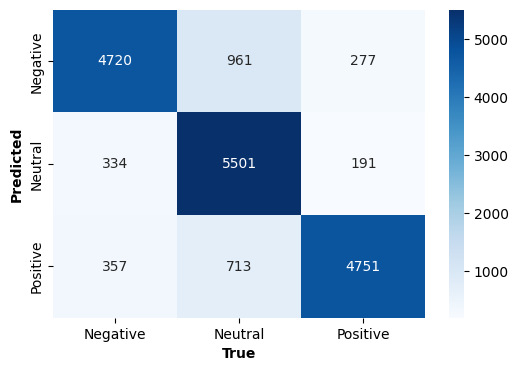

In [ ]:
bcb_res = confusion_matrix(true, preds)

plt.figure(figsize=(6, 4))
ax=sns.heatmap(bcb_res, annot=True, cmap='Blues', fmt='d',
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('True', fontweight='bold')
plt.ylabel('Predicted', fontweight='bold')
plt.show()

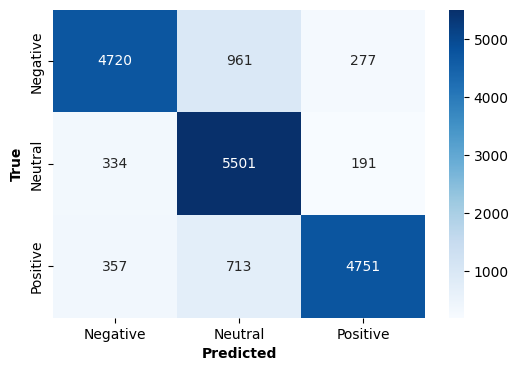

In [ ]:
plt.figure(figsize=(6, 4))
ax=sns.heatmap(bcb_res, annot=True, cmap='Blues', fmt='d',
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted', fontweight='bold')
plt.ylabel('True', fontweight='bold')
plt.show()